# Casimir Athena

[Athena](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena.html) integrated data environment and query sandbox

## Table of Contents

* [Install Packages](#install-packages)
* [Configure Athena](#configure-athena)
* [Sample Usage](#sample-usage)

### Install Packages

The primary package is pyathena, which is a Python library for querying Amazon Athena that abstracts result-retrieval, and we use it to return a pandas dataframe for easy handling and further analysis.

In [220]:
# Interact with AWS credentials and environment overrides
import os
from dotenv import load_dotenv
import boto3
import boto3.session

# Query Athena
from pyathena import connect

# Handle results
import warnings
import pandas as pd
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

### Configure Athena

We use the AWS credentials from your configured AWS profile (default `consensus-networks-dev`) to initialize the pyathena connection and define a DB query method.

In [221]:
load_dotenv()
PROFILE=os.getenv('PROFILE')
profile = PROFILE or 'consensus-networks-dev'
session = boto3.Session(profile_name=profile)
creds = session.get_credentials()

connection = connect(
    aws_access_key_id=creds.access_key, 
    aws_secret_access_key=creds.secret_key, 
    s3_staging_dir="s3://casimir-etl-output-bucket-dev/", 
    region_name="us-east-2"
)

def db_query(sql_query: str) -> pd.DataFrame:
    """Execute SQL Query and get pandas dataframe"""
    with warnings.catch_warnings():
        # Ignore warning for non-SQLAlchemy connecton
        warnings.simplefilter('ignore', UserWarning)
        df = pd.read_sql_query(sql_query, connection)
    return df

> 🚩 You can override the default profile name by setting PROFILE in your project root `.env` file. See [Environment](../../../README.md#environment) for more information.

### Sample Usage

Get new stake volume per candidate for the month of August (2021) sorted by day.

> 🚧 WIP – need to cleanup grouping/labels.

            day staked_candidate     amount
0    2021-08-01      binancevote   114685.0
1    2021-08-01        coingecko   113301.0
2    2021-08-01         iotexlab     5584.0
3    2021-08-01          satoshi   113000.0
4    2021-08-01              cpc      500.0
..          ...              ...        ...
460  2021-08-28          mrtrump  1421350.0
461  2021-08-28     consensusnet  2089375.0
462  2021-08-29        iotexteam      673.0
463  2021-08-29      binancevote      100.0
464  2021-08-29        emmasiotx      100.0

[465 rows x 3 columns]


<AxesSubplot:xlabel='day', ylabel='amount'>

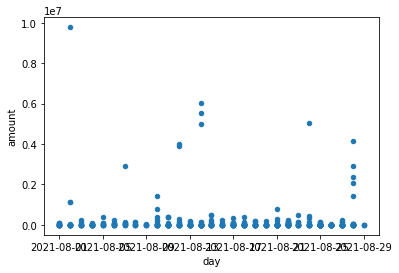

In [242]:
query = """
        SELECT date_trunc('day', datestring) as day, staked_candidate, SUM(CAST(staked_amount AS decimal) / power(10, 18)) AS amount
        FROM casimir_etl_database_dev.casimir_etl_event_table_dev
        WHERE staked_candidate = 'consensusnet' AND type = 'create_stake' AND date_trunc('day', datestring) BETWEEN date '2021-08-01' AND date '2021-08-31'
        GROUP BY date_trunc('day', datestring), staked_candidate
        ORDER BY date_trunc('day', datestring)
        """
        
dataframe = db_query(query)
print(dataframe)
dataframe.plot(kind='scatter', x='day', y='amount', cmap=cmap)